In [58]:
# You can import *ANYTHING* you want here.
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error # Requires sklearn 0.24 (December 2020), update with conda/pip if needed.
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold

import pandas as pd

# Grade: /100 pts

# Assignment 6: Tree methods

In this assignment you'll study tree methods and their capabilities as interpolators and extrapolators, as well you'll realize the importance of understanding your data!. You will use a dataset that contains house sale prices for King County, which includes Seattle. It includes homes sold between May 2014 and May 2015.The data has the following variables:

- price: Prediction target

- bedrooms: Number of Bedrooms/House

- bathrooms: Number of bathrooms/bedrooms

- sqft_living: square footage of the home

- sqft_lot: square footage of the lot

- floors :Total floors (levels) in house

- waterfront: House which has a view to a waterfront

- view: Has been viewed

- condition: How good the condition is Overall

- grade: overall grade given to the housing unit, based on King County grading system.

- sqft_above :square footage of house apart from basement.

- sqft_basement: square footage of the basement.

- yr_built :Built Year.

- yr_renovated :Year when house was renovated.

- zipcode:zip code.

- lat: Latitude coordinate.

- long: Longitude coordinate.

- sqft_living15 :Living room area in 2015(implies-- some renovations) This might or might not have affected the lotsize area.

- sqft_lot15 :lotSize area in 2015(implies-- some renovations).

You are given two datasets: HousePrice_Part_1.csv and HousePrice_Part_2.csv. The first dataset contains houses with price between 30k to 50k, while the second one is a complementary dataset which contains the houses with price less than 30k.

*Do not forget to include labels in your figures.*

## Task 1: Random Forests (35 pts)

Random Forests are excellent predictors. Usually we only need to tune one parameter: the number of trees in the model. However, how many trees are enough? Follow these steps:

1. Load the training dataset (HousePrice_Part_1.csv) and show the descriptive statistics of the variables. (3 pts)

2. Create a train / test partition of the data using 30% of the data for the test set and a ```random_state``` value of 20220309 (2 pts).

3. Follow [this example](https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html) and train a [Random Forest Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) using ```price``` as the target variable with different ```max_features```. Test between 175 and 375 trees, plotting the Out-of-Bag (OOB) error after every iteration. Be patient as training can take a while. Which max_features gives the lowest OOB rate?(15 pts)

4. Train your final random forest with the 350 as number of trees and the best max_feature method you found in question 3. Apply this model over your test set and over the extrapolating dataset (from the file ```HousePrice_Part_2.csv``` which contain the lowest 20% sale prices data), calculating the mean absolute percentual error for each dataset.  Show in a scatterplot the predicted value vs the real value of the target variable for both the test set and the complementary set (in the same plot), differentiating both by using different colors for the points. Written answer: How does the random forest model perform on predicting house price in the complementary data set? If it performs poorly, why? If it performs well, why? *Hint: look at the MAPE and plot*. (15 points)

In [7]:
# Data load # 3pts
df = pd.read_csv('HousePrice_Part_1.csv')
df.head()
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000
mean,385674.460571,3.235571,1.962679,1782.393857,12666.674000,1.456357,0.001429,0.095857,3.368857,7.287571,1549.870286,232.523571,1972.794143,55.218000,98082.501571,47.562112,-122.217667,1780.018143,11309.381429
std,48955.848511,0.861501,0.644978,598.400785,30642.344792,0.554234,0.037772,0.468569,0.615977,0.748587,571.711133,369.478222,28.215468,327.096284,51.514097,0.146521,0.143171,465.599637,23818.764099
min,303000.000000,0.000000,0.000000,410.000000,600.000000,1.000000,0.000000,0.000000,1.000000,4.000000,410.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.511000,460.000000,748.000000
25%,342500.000000,3.000000,1.500000,1330.000000,4800.000000,1.000000,0.000000,0.000000,3.000000,7.000000,1130.000000,0.000000,1954.000000,0.000000,98034.000000,47.452500,-122.334000,1420.000000,5000.000000
50%,385000.000000,3.000000,2.000000,1730.000000,7285.000000,1.000000,0.000000,0.000000,3.000000,7.000000,1400.000000,0.000000,1976.000000,0.000000,98072.000000,47.553600,-122.250000,1710.000000,7350.500000
75%,428787.500000,4.000000,2.500000,2170.000000,9822.750000,2.000000,0.000000,0.000000,4.000000,8.000000,1890.000000,440.000000,1999.000000,0.000000,98125.000000,47.701200,-122.138000,2080.000000,9500.000000
max,475000.000000,9.000000,7.500000,5067.000000,542322.000000,3.500000,1.000000,4.000000,5.000000,11.000000,4190.000000,2100.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.321000,4362.000000,386812.000000


In [51]:
# Create train / test split #2pt
RAND_STATE = 20220309

y = df.price
X = df.drop('price', axis = 'columns')

Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size = 0.30, random_state = RAND_STATE)
print(Xtrain.shape, Xtest.shape)

(4900, 18) (2100, 18)


C:\Users\VBran\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\VBran\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\VBran\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


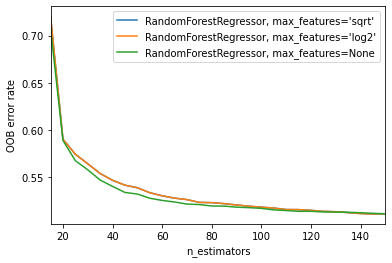

In [104]:
# OOB error rate #10 pts
ensemble_clfs = [
    (
        "RandomForestRegressor, max_features='sqrt'",
        RandomForestRegressor(
            warm_start=True,
            oob_score=True,
            max_features="sqrt",
            random_state=RAND_STATE,
        ),
    ),
    (
        "RandomForestRegressor, max_features='log2'",
        RandomForestRegressor(
            warm_start=True,
            max_features="log2",
            oob_score=True,
            random_state=RAND_STATE,
        ),
    ),
    (
        "RandomForestRegressor, max_features=None",
        RandomForestRegressor(
            warm_start=True,
            max_features=None,
            oob_score=True,
            random_state=RAND_STATE,
        ),
    ),
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 150

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 5):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))



## plot # 4 pts

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [128]:
# Final forest #8pts
# Assume your trees become stable around  350

house_rf = RandomForestRegressor(n_estimators=350, # Number of trees to train
                       max_depth=None, # Max depth of the trees. Not necessary to change.
                       min_samples_split=2, # Minimum samples to create a split.
                       min_samples_leaf=0.001, # Minimum samples in a leaf. Accepts fractions for %. This is 0.1% of sample.
                       min_weight_fraction_leaf=0.0, # Same as above, but uses the class weights.
                       max_features=None, # Maximum number of features per split (not tree!) by default is sqrt(vars)
                       max_leaf_nodes=None, # Maximum number of nodes.
                       min_impurity_decrease=0.0001, # Minimum impurity decrease. This is 10^-3.
                       bootstrap=True, # If sample with repetition. For large samples (>100.000) set to false.
                       oob_score=True,  # If report accuracy with non-selected cases.
                       n_jobs=-1, # Parallel processing. Set to -1 for all cores. Watch your RAM!!
                       random_state=RAND_STATE, # Seed
                       verbose=0, # If to give info during training. Set to 0 for silent training.
                       warm_start=False, # If train over previously trained tree.
                                )

house_rf.fit(Xtrain, ytrain)

# Calculate error over test set
rf_pred = house_rf.predict(Xtest)
mapeTest = mean_absolute_percentage_error(ytest,rf_pred)

# Load the second dataset
df2 = pd.read_csv('HousePrice_Part_2.csv')
ynew = df2.price
Xnew = df2.drop('price', axis = 'columns')

rf_pred2 = house_rf.predict(Xnew)
mapeExtra = mean_absolute_percentage_error(ynew, rf_pred2)

# Calculate the test set

In [138]:
#Print MAPE over the test set #2pts
print('Over a random test set, the MAPE of the Random Forest model is', mapeTest)
print('Over the extrapolation set, the MAPE of the Random Forest model is', mapeExtra)

Over a random test set, the MAPE of the Random Forest model is 0.07398719680986984
Over the extrapolation set, the MAPE of the Random Forest model is 0.4730254017520976


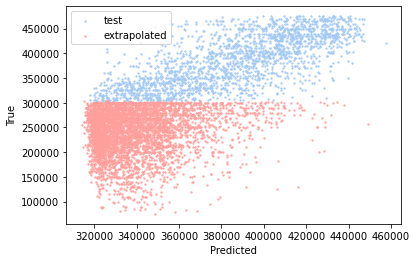

In [137]:
# Make the plot #2pts


fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(rf_pred, ytest, s=2, c='b', marker="o", label='test', alpha = 0.8)
ax1.scatter(rf_pred2, ynew, s=2, c='r', marker="o", label='extrapolated', alpha = 0.8)
plt.legend(loc='upper left');
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

**Written answer (3 pts):** The model permorms poorly. The MAPE value for the complimentary set is really high at 47%. Also the graph shows that the majority of the extrapolated predictions don't follow the same trend as the test predictions.

## Task 2: XGBoosting model (40 pts)

Now we'll repeat the process for the XGB model, using an [```XGBRegressor``` object](https://xgboost.readthedocs.io/en/latest/python/python_api.html). The XGBoosting model is much more sensitive to parameter changes though as it allows to tune many different parameters. For this example:

1. Written answer: Why do we say we want to use a small learning rate? Why do we say the number of trees to use depends on each dataset/problem? Why do we want to use a small tree depth? (6 pts)

2. Selecting a 30% validation sample over the training set, tune your parameters using crossvalidation. Use the following ranges:
 - Learning rate: [0.01, 0.1, 0.2].
 - max_depth: 4 to 7.
 - Number of trees: [350, 400, 450, 500]

Leave the other parameters at the values we identified in the lab (except for the objective parameter and those related to classification problems) and use a seed of 20220309. Report the optimal values of your parameters. (20 pts)

3. Repeat part 4 of the previous task, but now for your XGB model trained over the optimal parameter combination and the complete training dataset. Plot the variable importance. Written answer: What are the most important variables? Can the XGB model extrapolate? How does it compare to a random forest? (14 pts)

**Written answer (2 pts each):**


In [139]:
# Define the XGB model # 6pts
XGB_House = XGBRegressor(max_depth=3,                 # Depth of each tree
                            learning_rate=0.1,            # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                            n_estimators=300,             # How many trees to use, the more the better, but decrease learning rate if many used.
                            objective='reg:squarederror',  # Type of target variable
                            random_state=RAND_STATE        # Seed
                            )

In [140]:
# Define the parameters. Play with this grid! #3 pts
param_grid = dict({'n_estimators': [350, 400, 450, 500],
                   'max_depth': [4, 5, 6, 7],
                 'learning_rate' : [0.01, 0.1, 0.2]
                  })
param_grid

{'n_estimators': [350, 400, 450, 500],
 'max_depth': [4, 5, 6, 7],
 'learning_rate': [0.01, 0.1, 0.2]}

In [141]:
# Always a good idea to tune on a reduce sample of the train set, as we will call many functions. #6 pts
val_train = Xtrain.sample(frac = 0.3, random_state = RAND_STATE)
val_train_target = ytrain.sample(frac = 0.3, random_state = RAND_STATE)
# cv object
cv_object = StratifiedKFold(n_splits=3)

# Define grid search object.
GridXGB = GridSearchCV(XGB_House,        # Original XGB. 
                       param_grid,          # Parameter grid
                       cv = cv_object,      # Cross-validation object.  
                       scoring = 'roc_auc', # How to rank outputs.
                       n_jobs = -1,          # Parallel jobs. -1 is "all you have"
                       refit = False,       # If refit at the end with the best. We'll do it manually.
                       verbose = 1          # If to show what it is doing.
                      )

In [142]:
# Train grid search. This takes a while! Go grab a coffee. #2 pts
GridXGB.fit(val_train, val_train_target)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


C:\Users\VBran\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\VBran\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=3, min_chi...
                                    n_estimators=300, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=20220309, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                   

In [143]:
# Show best params #3pts
GridXGB.best_params_

{'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 350}

In [ ]:
# Define the XGB model # 3pts
XGB_House = XGBRegressor(max_depth=4,                 # Depth of each tree
                            learning_rate=0.01,            # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                            n_estimators=350,             # How many trees to use, the more the better, but decrease learning rate if many used.
                            objective='reg:squarederror',  # Type of target variable
                            random_state=RAND_STATE        # Seed
                            )

In [69]:
# Fit! #1pt
XGB_House.fit(Xtrain, ytrain)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=300, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=20220309,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

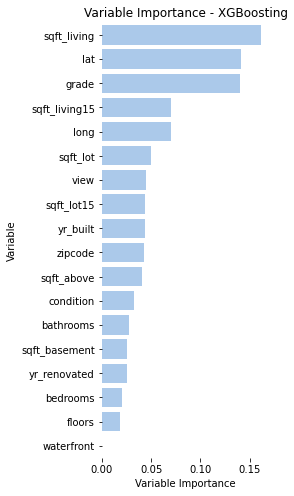

In [70]:
# Variable importance #4 pts
importances = XGB_House.feature_importances_
indices = np.argsort(importances)[::-1] 

f, ax = plt.subplots(figsize=(3, 8))
plt.title("Variable Importance - XGBoosting")
sns.set_color_codes("pastel")
sns.barplot(y=[Xtrain.columns[i] for i in indices], x=importances[indices], 
            label="Total", color="b")
ax.set(ylabel="Variable",
       xlabel="Variable Importance")
sns.despine(left=True, bottom=True)

# Answer about variable importance in the below cell.

**Written answer (2 pts):**

In [ ]:
# Now the answer is equivalent to T1. #2 pts


# Calculate the test set



#Print MAPE over the test set
#print('Over a random test set, the MAPE of the XGB model is ...
#print('Over the extrapolation set, the MAPE of the XGB model is ...
                                                                                                                        

# Plot

# Make the plot


**Written answer (2 pts):**

## Task 3: Combined model (25 pts)

Now we will finally train a model on the combined data, by joining the extrapolation and the original dataset, and study the performance over the original test set, the new test set and the combined result. For this we will only use the Random Forest model. Use a seed of 20220309 for all functions that accept one.

1. Create a train / test split set over the extrapolation data, leaving approximately 30% of the data for testing purposes. Combine this train test with the original train set (let's call this the combined train set). (5 pts)
2. Train a Random Forest model over the **combined** train data. Discuss how many trees you used and why? (Consider a significant improvement if the change in the OOB error rate is greater then 0.001). (5 pts)
3. Plot the variable importance and compare it versus the XGB in task 1. Now that you have more data, does the importance change? (5 pts)
3. Report the test set performance of your new model over the original test set, the test set you took over the extrapolation dataset and the combined test set. Plot the scatterplot of the both datasets as before in the same plot, differentiating the dataset by using colours. 
Written answer: What happens now? What can you say about the new model? (10 pts)

In [144]:
# Create train / test split of the extrapolation data #2 pts

Xtrain2, Xtest2, ytrain2, ytest2 = train_test_split(Xnew,ynew, test_size = 0.30, random_state = RAND_STATE)

# Combined sets #3 pts
XTrain = pd.concat([Xtrain, Xtrain2], ignore_index = True)
XTest = pd.concat([Xtest, Xtest2], ignore_index = True)
yTrain = pd.concat([ytrain, ytrain2], ignore_index = True)
yTest = pd.concat([ytest, ytest2], ignore_index = True)



**To get the optimal number of trees you will start from 175 trees. It does not make much sense to have less if I have more and more complex data.**

In [145]:
# Define random forest # 2
house_rf2 = RandomForestRegressor(n_estimators=175, # Number of trees to train
                       max_depth=None, # Max depth of the trees. Not necessary to change.
                       min_samples_split=2, # Minimum samples to create a split.
                       min_samples_leaf=0.001, # Minimum samples in a leaf. Accepts fractions for %. This is 0.1% of sample.
                       min_weight_fraction_leaf=0.0, # Same as above, but uses the class weights.
                       max_features=None, # Maximum number of features per split (not tree!) by default is sqrt(vars)
                       max_leaf_nodes=None, # Maximum number of nodes.
                       min_impurity_decrease=0.0001, # Minimum impurity decrease. This is 10^-3.
                       bootstrap=True, # If sample with repetition. For large samples (>100.000) set to false.
                       oob_score=True,  # If report accuracy with non-selected cases.
                       n_jobs=-1, # Parallel processing. Set to -1 for all cores. Watch your RAM!!
                       random_state=RAND_STATE, # Seed
                       verbose=0, # If to give info during training. Set to 0 for silent training.
                       warm_start=False, # If train over previously trained tree.
                                )

house_rf2.fit(XTrain, yTrain)

# Range of `n_estimators` values to explore.


# Define error list
rf_pred2 = house_rf2.predict(XTest)

# iterate over forest


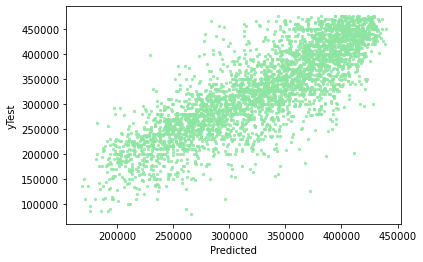

In [149]:
# Plot #2
fig2 = plt.figure()
ax1 = fig2.add_subplot(111)
ax1.scatter(rf_pred2, yTest, s=5, c='g', marker="o", alpha = 0.8)
plt.xlabel("Predicted")
plt.ylabel("yTest")
plt.show()

**Written Answer (1 pts):**

In [ ]:
# Final forest

# Calculate error over test set
mapeTest2 = mean_absolute_percentage_error(yTest,rf_pred2)

# Calculate error over test set

# Calculate the test set


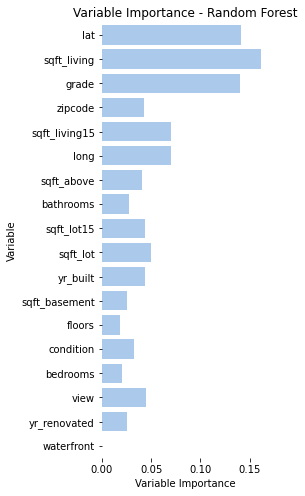

In [150]:
# Variable importance # 3pts
importances2 = house_rf2.feature_importances_
indices = np.argsort(importances2)[::-1] 

f, ax = plt.subplots(figsize=(3, 8))
plt.title("Variable Importance - Random Forest")
sns.set_color_codes("pastel")
sns.barplot(y=[Xtrain.columns[i] for i in indices], x=importances[indices], 
            label="Total", color="b")
ax.set(ylabel="Variable",
       xlabel="Variable Importance")
sns.despine(left=True, bottom=True)

**Written answer (2 pts):** Variable importance has changed with the addition of more data.

In [ ]:
# Print MAPE over the test set #2 pts
# print('Over a random test set, the MAPE of the Random Forest model is ...
# print('Over a random test set (non-extrapolation), the MAPE of the Random Forest model is ...
# print('Over the extrapolation set, the MAPE of the Random Forest model is ...

In [1]:
# Make the plot #1 pts


**Written answer (2 pts):**


Always understand the limitations of your datasets! You won't be able to create models that are always good for every situation.

## **Follow These Steps Before Submitting**
**Once you are finished, ensure to complete the following steps**.

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.

5.  Your submission document should be saved in the form: `LastName_FirstName_Assignment6.ipynb`

